In [4]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, classification_report
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [6]:
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'D:\DNN\images' # location of the images
modelDir = '../models'
altName = '?????'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 256

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [9]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [11]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [12]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [13]:
class_labels = {0: 'GK', 1: "Defender", 2:"Mid Fielder", 3:"Forward"}

In [14]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

X.shape, y.shape

((18147, 33), (18147,))

In [15]:
#  Split the data in training and test sets to measure performance of the model.
train_df , test_df = train_test_split(data_df,
                                                    test_size=TEST_SIZE, 
                                                    stratify=data_df['Position'], 
                                                    random_state=RANDOM_STATE )

print (train_df.shape, test_df.shape)

(14517, 34) (3630, 34)


In [16]:
class GlobalScaler:
    _instance = None

    def __init__ (self)->None:
        if GlobalScaler._instance is not None:
            raise Exception(" GlobalScaler CLASS IS SINGLETON")
        
        self.scaler = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScaler()
        return cls._instance

In [17]:



class FifaDs(Dataset):
    globalScaler = GlobalScaler.get_instance()

    def __init__(self, dataframe: pd.DataFrame, device: str = device, is_train = True, label_col=None) :

        self.device = device
        self.is_train = is_train
        self.label_col = label_col
        self.df = dataframe
        self.scaler = self.globalScaler.scaler
        self.labels = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis=1)

        if self.is_train:
            self.features = self.scaler.fit_transform(X)
        else:
            self.features = self.scaler.transform(X)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        features = self.features[index]
        label = self.labels[index]

        features = torch.tensor(features, dtype=torch.float32, device=self.device)

        label = torch.tensor(label, dtype=torch.int64, device=self.device)

        return features, label





In [18]:
label_cols = "Position"
train_ds = FifaDs(train_df, is_train=True, label_col=label_cols)
test_ds = FifaDs(test_df, is_train=False, label_col=label_cols)


In [19]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184]),
 tensor(3))

In [20]:
input_shape = train_df.shape[-1] -1
input_shape

33

In [21]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.activ1 = nn.SiLU()
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        x = F.softmax(self.layer2(x), dim = 1)
        return x

net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (activ1): SiLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [22]:


train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=True)



In [23]:
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss , tloss = [] , []
acc , tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr = ALPHA)


for epoch in range(EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')
    
   

At epoch 0 | Loss - train:1.3127, test:1.2319 | Acc - train:0.4703, test:0.6981
At epoch 5 | Loss - train:0.9245, test:0.9238 | Acc - train:0.8301, test:0.8287
At epoch 10 | Loss - train:0.8872, test:0.8933 | Acc - train:0.8625, test:0.8543
At epoch 15 | Loss - train:0.8756, test:0.8836 | Acc - train:0.8724, test:0.8581
At epoch 20 | Loss - train:0.8708, test:0.8794 | Acc - train:0.8752, test:0.8647
At epoch 25 | Loss - train:0.8677, test:0.8776 | Acc - train:0.8772, test:0.8645
At epoch 30 | Loss - train:0.8656, test:0.8763 | Acc - train:0.8795, test:0.8656
At epoch 35 | Loss - train:0.8638, test:0.8742 | Acc - train:0.8805, test:0.8686
At epoch 40 | Loss - train:0.8624, test:0.8722 | Acc - train:0.8816, test:0.8697
At epoch 45 | Loss - train:0.8610, test:0.8718 | Acc - train:0.8834, test:0.8702
At epoch 50 | Loss - train:0.8601, test:0.8699 | Acc - train:0.8848, test:0.8719
At epoch 55 | Loss - train:0.8592, test:0.8699 | Acc - train:0.8854, test:0.8716
At epoch 60 | Loss - train:0.8

In [25]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.312727,1.231913,0.470345,0.698072
1,1,1.146221,1.063853,0.739822,0.769697
2,2,1.018005,0.984433,0.785493,0.791736
3,3,0.963916,0.953003,0.805194,0.806336
4,4,0.939578,0.935772,0.819729,0.818182


In [34]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

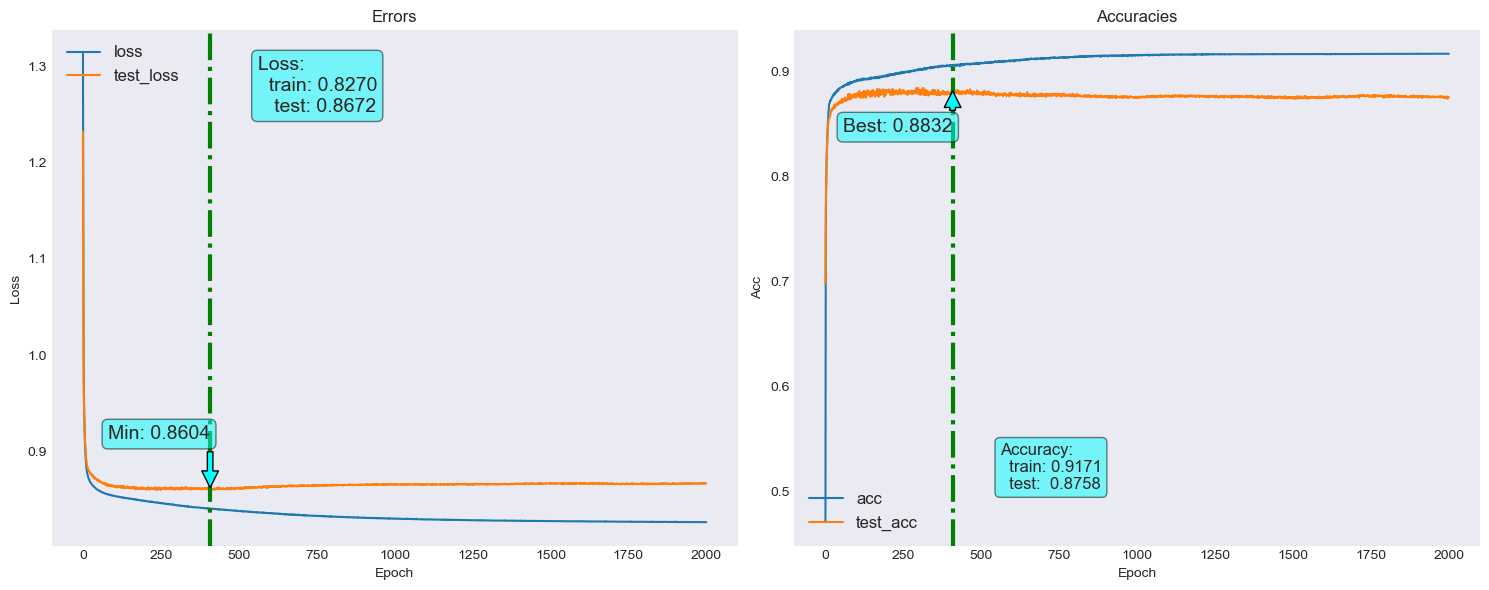

In [35]:
fn_plot_torch_hist(loss_df)

In [36]:
print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.94      0.95      0.95      4693
           2       0.88      0.91      0.89      5470
           3       0.91      0.82      0.86      2734

    accuracy                           0.92     14517
   macro avg       0.93      0.92      0.93     14517
weighted avg       0.92      0.92      0.92     14517



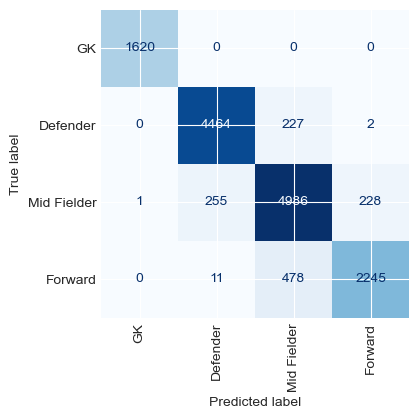

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [38]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):

    inputs, labels = data

    outputs = net(inputs)

    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [39]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.82      0.87      0.84      1368
           3       0.84      0.74      0.78       684

    accuracy                           0.88      3630
   macro avg       0.89      0.88      0.89      3630
weighted avg       0.88      0.88      0.88      3630



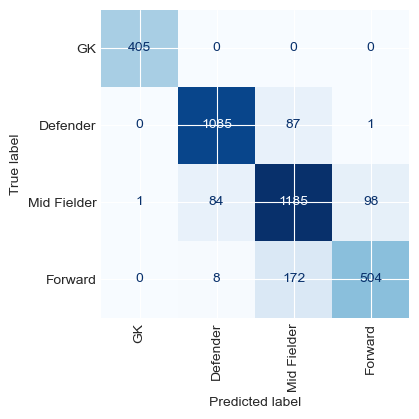

In [40]:
cmt  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cmt,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();